### Exploratory Data Analysis

In [1]:
import os

In [2]:
os.chdir("../")
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection'

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
# Config
ROOT_DIR = "artifacts/data_ingestion/Combined_Training_Data"
CLASSES = ["Stone", "Non-Stone"]
SAMPLE_SIZE_PER_CLASS = 100 

Class Distribution:
  Stone: 18194 images
  Non-Stone: 20627 images


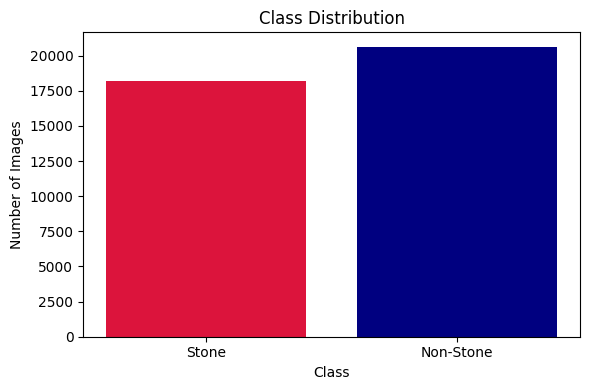

In [25]:
# Count images per class
class_counts = {}
print("Class Distribution:")
for cls in CLASSES:
    cls_path = os.path.join(ROOT_DIR, cls)
    img_count = len([
        f for f in os.listdir(cls_path)
        if f.lower().endswith(('.jpg', '.png', '.jpeg'))
    ])
    class_counts[cls] = img_count
    print(f"  {cls}: {img_count} images")

# Plot the class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['crimson', 'navy'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

In [24]:
# Sample images and gather size stats
widths = []
heights = []
sample_images = []

for cls in CLASSES:
    folder = os.path.join(ROOT_DIR, cls)
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:SAMPLE_SIZE_PER_CLASS]
    for file in files:
        path = os.path.join(folder, file)
        img = Image.open(path).convert("L")
        widths.append(img.width)
        heights.append(img.height)
        sample_images.append((img, cls))

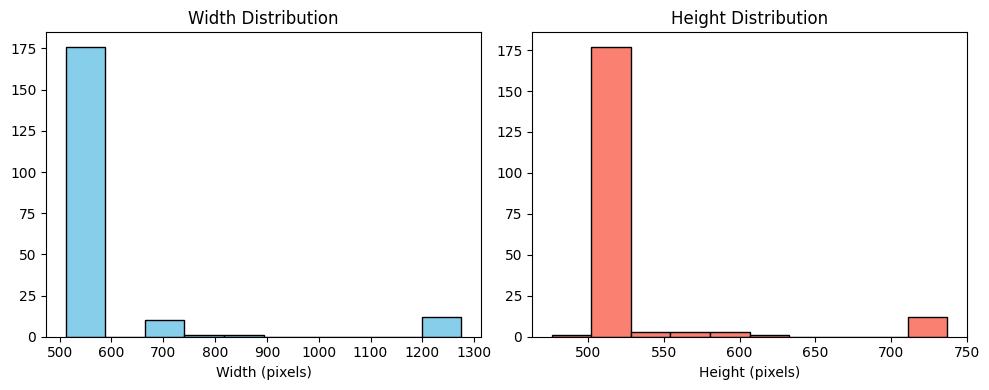

In [9]:
# Plot image size distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=10, color='skyblue', edgecolor='black')
plt.title("Width Distribution")
plt.xlabel("Width (pixels)")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=10, color='salmon', edgecolor='black')
plt.title("Height Distribution")
plt.xlabel("Height (pixels)")

plt.tight_layout()
plt.show()

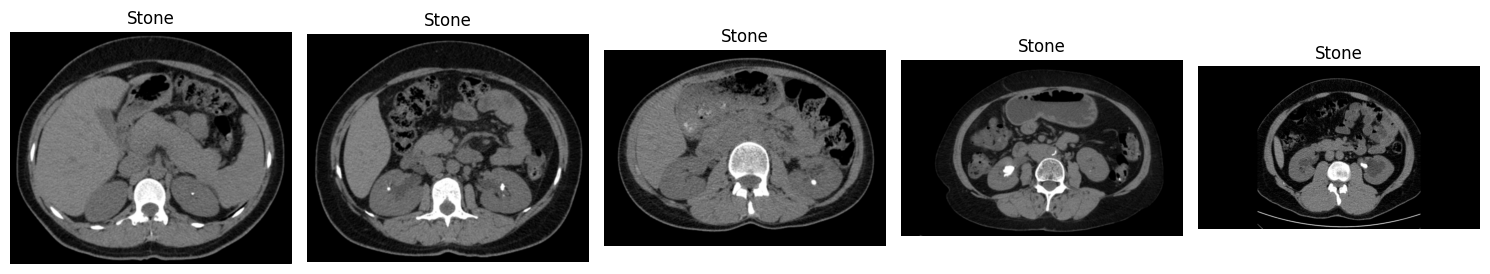

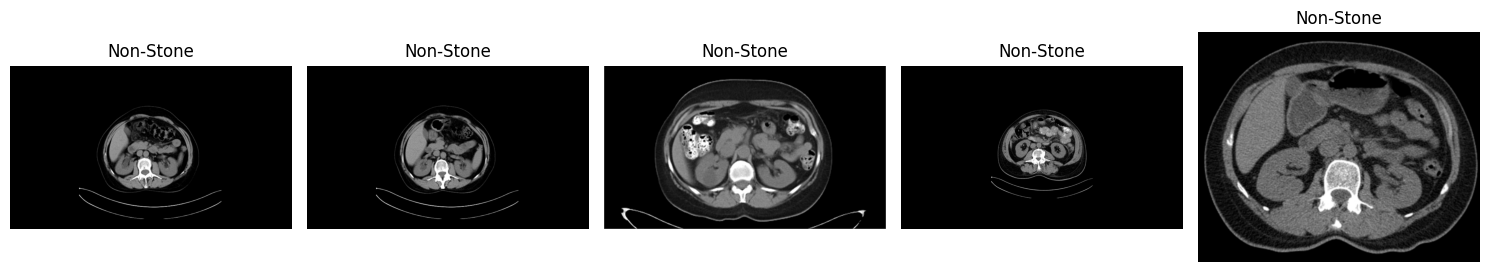

In [10]:
# Show a few sample images
def show_samples(samples, label, n=5):
    filtered = [img for img, lbl in samples if lbl == label][:n]
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(filtered):
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(sample_images, "Stone", n=5)
show_samples(sample_images, "Non-Stone", n=5)

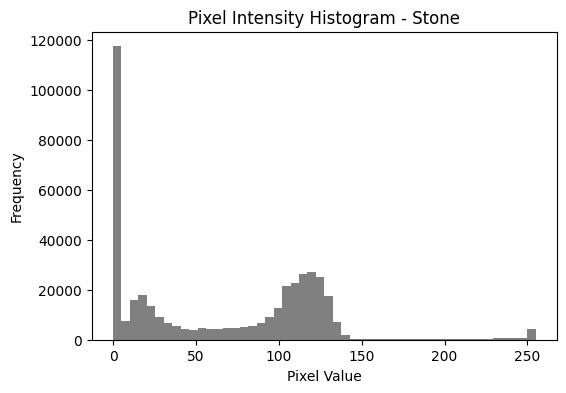

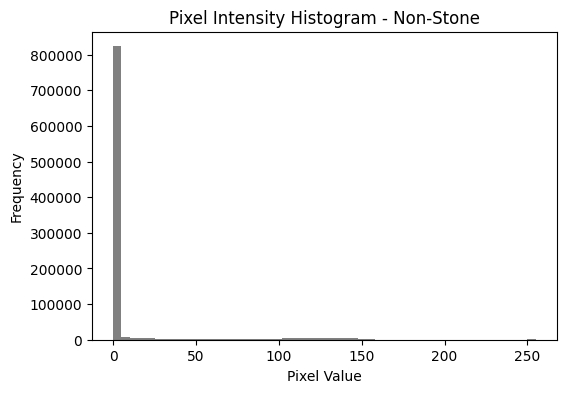

In [29]:
# Plot intensity histogram for one image from each class
for cls in CLASSES:
    img = next(img for img, lbl in sample_images if lbl == cls)
    plt.figure(figsize=(6,4))
    plt.hist(np.array(img).ravel(), bins=50, color='gray')
    plt.title(f"Pixel Intensity Histogram - {cls}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

### Data Preprocessing

In [12]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

In [13]:
# Constants
ROOT_DIR = "artifacts/data_ingestion/Combined_Training_Data"
CLASSES = ["Stone", "Non-Stone"]
IMG_SIZE = 256

In [14]:
# Get all image paths and labels
image_paths = []
labels = []

for label in CLASSES:
    folder = os.path.join(ROOT_DIR, label)
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, file))
            labels.append(label)

In [15]:
# Train-test split (stratified)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Transformation pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # Converts to range [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [16]:
# Custom Dataset
class KidneyCTDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [0 if lbl == "Non-Stone" else 1 for lbl in labels]  # Binary: 0=non-stone, 1=stone
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [17]:
# Datasets
train_dataset = KidneyCTDataset(train_paths, train_labels, transform)
test_dataset = KidneyCTDataset(test_paths, test_labels, transform)

In [18]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [19]:
# Sample check
print(f"Train Images: {len(train_dataset)}")
print(f"Test Images: {len(test_dataset)}")

Train Images: 31056
Test Images: 7765
